In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.ndimage import gaussian_filter1d
from IPython import display

## Notebook organization:
#### This notebook contains 4 training sets: linear 3-label, non-linear 3-label, linear 2-label, and non-linear 2-label. For each, there are two cells. One prints the training information periodically. The other shows a live update plot of the loss and classification (executing this second cell takes longer due to the computing power it requires to update the plots).

### Activation functions and their derivatives

In [2]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_prime(x):
    return x*(1-x)

def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1.0-x**2.0

def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

def softmax_prime(x):
    return x*(1-x)

### NeuralNetwork class

In [3]:
class NeuralNetwork:
    def __init__(self, layers, activation='sigmoid'):
        '''
        Initializes a new instance of NeuralNetwork.

        :layers: specifies the architecture (n_inputs, <hidden layers>, n_labels)
        :activation: specifies the activation function of the hidden layers with "tanh" or "sigmoid", output is always softmax
        :return: None
        '''
        self.layers = layers
        self.n_layers = len(layers)
        if activation == 'sigmoid':
          self.activation, self.activation_prime = sigmoid, sigmoid_prime
        else:
          self.activation, self.activation_prime = tanh, tanh_prime
        
    def fit(self, X, y, learning_rate=0.2, live_update = True, steps=100000, tol=1e-1,average_step_metric=50,update_step=100):
        '''
        Trains the model

        :X: numpy array containing training data without bias
        :y: numpy array containg labels for each training point
        :learning_rate: scales the correction to the weights
        :live_update: shows a live plot for the boundaries and the loss curve
        :steps: # of trainignsteps
        :tol: training is stopped once tol has been reached in the loss curve
        :average_step_metric: determines the # of steps used to average the loss to determine termination
        :update_step: determines the step interval in-between live updates.
        :return: None
        '''
        #Globalizing training data:
        self.X=X
        self.y=y
        
        #initialize weights:
        np.random.seed(1)
        self.W=[]
        for inter_layer in range(self.n_layers-1):
            layer_before=inter_layer
            layer_after=inter_layer+1
            self.W.append(np.random.randn(self.layers[inter_layer]+1, self.layers[layer_after])) #+1 for bias
        #start training:
        steps_to_display=np.round(np.linspace(0,steps,11),0)
        loss=[]
        training_stopped=False
        for training_step in range(steps):
            #Chosing training data:
            n = random.randint(0, self.y.shape[0]-1)
            target = y[n]
            x=X[n]
            x=np.concatenate((np.array([1]),x))
            
            #Clearing lists from previous step/declaring lists for 0th step:
            self.a=[]
            self.activation_of_a=[x]
            
            #Forward propagation:
            for inter_layer in range(self.n_layers-1):
                layer_before=inter_layer
                layer_after=inter_layer+1
                dot_product=np.dot(np.atleast_2d(self.activation_of_a[layer_before]),self.W[layer_before])
                self.a.append(dot_product)
                
                #If statement treats the last layer's act. func. separately since it must use softmax instead of the other activation functions
                if inter_layer != self.n_layers-2:
                    self.activation_of_a.append(np.insert(self.activation(dot_product),0,1))
                else:
                    self.activation_of_a.append(softmax(dot_product))
            loss.append(1/2*np.sum((target-self.activation_of_a[-1].flatten())**2))
                            
            #Check to end training if tol has been met:
            if training_step>=average_step_metric:
                avg_point_loss=sum(loss[-average_step_metric:])/average_step_metric
                steps_averaged=average_step_metric
            else:
                avg_point_loss=sum(loss)/len(loss)
                steps_averaged=len(loss)
            if avg_point_loss<=tol:
                if not live_update:
                    plt.figure()
                    plt.plot(gaussian_filter1d(loss,steps*0.0001))
                    plt.ylabel('Loss')
                    plt.xlabel('Training step')
                    plt.title(f'Training loss up to the {training_step}th step')
                training_stopped=True
                
            #Display training:
            if not live_update:
                if training_step in steps_to_display:
                    print(f'step: {training_step}\nTraining Results (data, prediction, expected):')
                    for n_test,x_test in enumerate(X):
                        _, output=self.predict(x_test)
                        print('{}, {}, {}'.format(x_test,np.round(output, decimals=2),y[n_test]))
                    print('{} step average loss: {:.2}\n'.format(steps_averaged, avg_point_loss))
            else:
                if training_step % update_step  == 0 or training_stopped: #or training_step==0 :
                    fig,axs=plt.subplots(1,2,figsize=(15,5))
                    axs[0].plot(gaussian_filter1d(loss,steps*0.001))
                    axs[0].set_ylabel('Loss')
                    axs[0].set_xlabel('Training step')
                    axs[0].set_title(f'Training loss up to the {training_step}th step')
                    self.visual_NN_boundaries_internal(X,axs[1])
                    display.clear_output(wait=True)
                    display.display(plt.gcf())
                    plt.clf()
                    plt.show()

            #Stopping training after showing last step
            if training_stopped:
                print('NN training succeeded!')
                break
                
            #Backwards propagation
            factor = np.atleast_2d(target-self.activation_of_a[-1].flatten())
            deltas = []
            for l in range(self.n_layers-1,0,-1): #Calculation of deltas
                if l == self.n_layers-1:#last layer:
                    g_prime = softmax_prime(np.atleast_2d(self.activation_of_a[-1]))
                else:
                    g_prime = self.activation_prime(np.atleast_2d(self.activation_of_a[l])[0,1:])
                deltas.append(np.atleast_2d(factor*g_prime))
                factor = np.dot(deltas[-1], self.W[l-1][0:-1, :].T)
            deltas.reverse()
            for l in range(self.n_layers-1,0,-1): #Update of weights
                delta_w = learning_rate*np.dot(np.atleast_2d(self.activation_of_a[l-1]).T, deltas[l-1])
                self.W[l-1] += delta_w

        #Check if training was succesful:
        if not training_stopped:
            print('NN training failed.')
        if not training_stopped and not live_update:
            plt.figure()
            plt.plot(gaussian_filter1d(loss,steps*0.001))
            plt.ylabel('Loss')
            plt.xlabel('Training step')
            plt.title(f'Training loss up to the {training_step}th step')
            
    def predict(self,x):
        '''
        Runs inference using the trained weights (forward propagation WITHOUT backwards propagation)
        
        :x: numpy array containg two points, x_o and x_1, to classify
        :returns: an array with the binary classification result (1 is assigned to the label with the highest value)
        '''
        #Chosing training data:
        x=np.concatenate((np.array([1]),x))

        #Clearing lists from previous step/declaring lists for 0th step:
        self.a=[]
        self.activation_of_a=[x]

        #Forward propagation:
        for inter_layer in range(self.n_layers-1):
            layer_before=inter_layer
            layer_after=inter_layer+1
            dot_product=np.dot(np.atleast_2d(self.activation_of_a[layer_before]),self.W[layer_before])
            #If statement treats the last layer's act. func. separately since it must use softmax instead of the other activation functions
            if inter_layer != self.n_layers-2:
                self.activation_of_a.append(np.insert(self.activation(dot_product),0,1))
            else:
                self.activation_of_a.append(softmax(dot_product))
        output=self.activation_of_a[-1]
        binary_output=np.zeros(output.shape)
        binary_output[0,np.argmax(output)]=1
        return binary_output, output
    
    def visual_NN_boundaries(self, X,Nsamp=2000):
        '''
        Uses color-coding to plot the boundaries separating the training points as determined by the training process.
        
        :X: takes in the training data, and plots it with yellow X's for reference
        :Nsamp: number of points to be randomly generated and classified
        '''
        colors=['red','blue','green']
        plt.figure()
        for i in range(Nsamp):
            x1, x2 = np.random.rand(), np.random.rand()
            binary_output,_ = self.predict(np.array([x1,x2]))
            for n_output,label_prediction in enumerate(binary_output[0]):
                if label_prediction ==1:
                    plt.scatter([x1],[x2], marker='o', color = colors[n_output],zorder=1)
        for n_target,x in enumerate(X):
            x1, x2 = x[0],x[1]
            binary_label=self.y[n_target]
            for n_target, label_target in enumerate(binary_label):
                if label_target==1:
                    plt.scatter(x1,x2, marker='X', facecolors = 'w',edgecolors=colors[n_target],zorder=2,s=250,linewidths=3)
        plt.title('Visual classification of {} pairs of points'.format(Nsamp))
        plt.show()
        
    def visual_NN_boundaries_internal(self, X,ax,Nsamp=500):
        '''
        Uses color-coding to plot the boundaries separating the training points as determined by the training process.
        Only used within the class during live-updates.
        
        :X: takes in the training data, and plots it with yellow X's for reference
        :Nsamp: number of points to be randomly generated and classified
        :ax: matplotlib axis where classification points will be plotted
        '''
        colors=['red','blue','green']
        points=np.random.rand(Nsamp,2)
        for point in points:
            binary_output,_ = self.predict(point)
            for n_output,label_prediction in enumerate(binary_output[0]):
                if label_prediction ==1:
                    plt.scatter(point[0],point[1], marker='o', color = colors[n_output],zorder=1)
        for n_target,x in enumerate(X):
            binary_label=self.y[n_target]
            for n_target, label_target in enumerate(binary_label):
                if label_target==1:
                    ax.scatter(x[0],x[1], marker='X', facecolors = 'w',edgecolors=colors[n_target],zorder=2,s=250,linewidths=3)



### Three-label linear training set:

##### Periodic printed updates:

step: 0
Training Results (data, prediction, expected):
[0. 0.], [[0.7  0.29 0.01]], [1 0 0]
[0.5 0.5], [[0.69 0.3  0.01]], [0 1 0]
[1. 1.], [[0.69 0.31 0.01]], [0 0 1]
1 step average loss: 0.78

step: 8000
Training Results (data, prediction, expected):
[0. 0.], [[0.5  0.48 0.02]], [1 0 0]
[0.5 0.5], [[0.51 0.47 0.02]], [0 1 0]
[1. 1.], [[0.01 0.07 0.92]], [0 0 1]
50 step average loss: 0.18

step: 16000
Training Results (data, prediction, expected):
[0. 0.], [[0.88 0.12 0.  ]], [1 0 0]
[0.5 0.5], [[0.09 0.82 0.09]], [0 1 0]
[1. 1.], [[0.   0.12 0.88]], [0 0 1]
50 step average loss: 0.018

NN training succeeded!


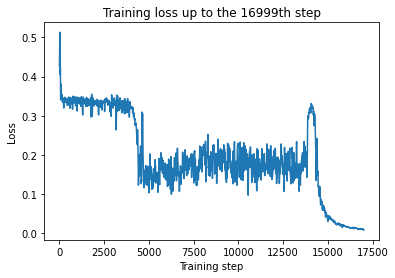

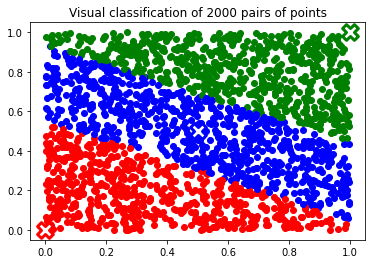

In [11]:
X=np.array([[0,0],
            [0.5,0.5],
            [1,1]])
y=np.array([[1,0,0],
            [0,1,0],
            [0,0,1]])

nn1 = NeuralNetwork([2,2,3], activation="tanh")

nn1.fit(X,y,steps=80000,learning_rate=0.2,tol=1e-2,update_step=500,live_update=False)
nn1.visual_NN_boundaries(X)

#### Live updates of loss and classification:

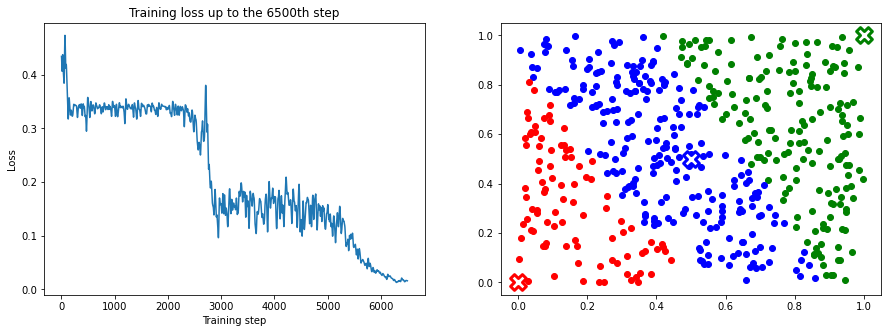

<Figure size 1080x360 with 0 Axes>

NN training succeeded!


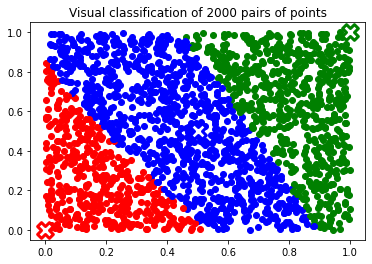

In [15]:
X=np.array([[0,0],
            [0.5,0.5],
            [1,1]])
y=np.array([[1,0,0],
            [0,1,0],
            [0,0,1]])

nn1 = NeuralNetwork([2,2,3], activation="tanh")

nn1.fit(X,y,steps=80000,learning_rate=0.2,tol=1e-2,update_step=500,live_update=True)
nn1.visual_NN_boundaries(X)

### Three-label non-linear training set #1

#### Periodic printed updates:

step: 0
Training Results (data, prediction, expected):
[0.5 1. ], [[0.89 0.01 0.1 ]], [1 0 0]
[1.  0.5], [[0.98 0.   0.02]], [1 0 0]
[0.5 0. ], [[0.97 0.   0.03]], [1 0 0]
[0.  0.5], [[0.97 0.   0.03]], [1 0 0]
[0.2 0.2], [[0.97 0.   0.03]], [0 1 0]
[0. 1.], [[0.87 0.01 0.12]], [0 1 0]
[0.5 0.8], [[0.96 0.   0.04]], [0 1 0]
[0.8 0.5], [[0.99 0.   0.01]], [0 1 0]
[0.5 0.2], [[0.99 0.   0.01]], [0 1 0]
[0.2 0.5], [[0.99 0.   0.01]], [0 1 0]
[1. 0.], [[0.99 0.   0.01]], [0 1 0]
[0.5 0.6], [[0.99 0.   0.01]], [0 0 1]
[0.6 0.5], [[0.99 0.   0.01]], [0 0 1]
[0.5 0.4], [[0.99 0.   0.01]], [0 0 1]
[0.4 0.5], [[0.99 0.   0.01]], [0 0 1]
1 step average loss: 0.88

step: 50000
Training Results (data, prediction, expected):
[0.5 1. ], [[0.81 0.18 0.01]], [1 0 0]
[1.  0.5], [[0.38 0.62 0.  ]], [1 0 0]
[0.5 0. ], [[0.12 0.6  0.28]], [1 0 0]
[0.  0.5], [[0.86 0.14 0.  ]], [1 0 0]
[0.2 0.2], [[0.06 0.34 0.6 ]], [0 1 0]
[0. 1.], [[0.26 0.73 0.01]], [0 1 0]
[0.5 0.8], [[0.08 0.38 0.54]], [0 1 0]
[0.8 0.

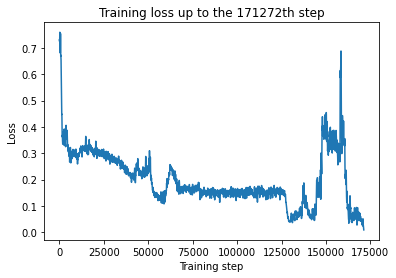

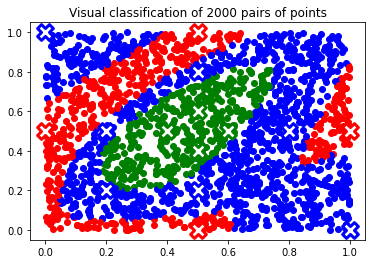

In [13]:
X = np.array([[0.5,1],
              [1,0.5],
              [0.5,0],
              [0,0.5],
              [0.2,0.2],
              [0,1],
              [0.5,0.8],
              [0.8,0.5],
              [0.5,0.2],
              [0.2,0.5],
              [1,0],
              [0.5,0.6],
              [0.6,0.5],
              [0.5,0.4],
              [0.4,0.5]])
y=np.array([[1,0,0],
            [1,0,0],
            [1,0,0],
            [1,0,0],
            [0,1,0],
            [0,1,0],
            [0,1,0],
            [0,1,0],
            [0,1,0],
            [0,1,0],
            [0,1,0],
            [0,0,1],
            [0,0,1],
            [0,0,1],
            [0,0,1]])

nn2 = NeuralNetwork([2,8,8,8,3], activation="tanh")

nn2.fit(X,y,steps=500000,learning_rate=0.02,tol=0.01,average_step_metric=100,update_step=100000,live_update=False)

nn2.visual_NN_boundaries(X)


#### Live updates of loss and classification:

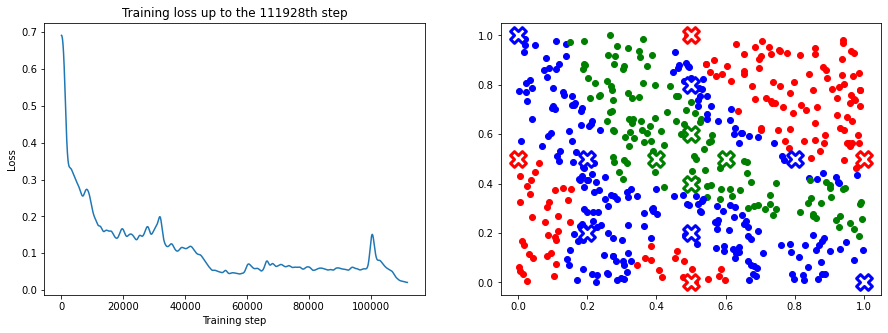

<Figure size 1080x360 with 0 Axes>

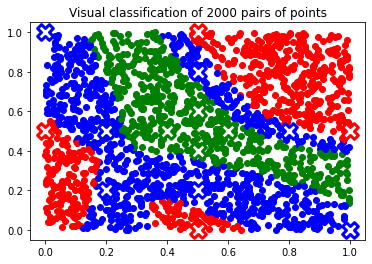

In [20]:
X = np.array([[0.5,1],
              [1,0.5],
              [0.5,0],
              [0,0.5],
              [0.2,0.2],
              [0,1],
              [0.5,0.8],
              [0.8,0.5],
              [0.5,0.2],
              [0.2,0.5],
              [1,0],
              [0.5,0.6],
              [0.6,0.5],
              [0.5,0.4],
              [0.4,0.5]])
y=np.array([[1,0,0],
            [1,0,0],
            [1,0,0],
            [1,0,0],
            [0,1,0],
            [0,1,0],
            [0,1,0],
            [0,1,0],
            [0,1,0],
            [0,1,0],
            [0,1,0],
            [0,0,1],
            [0,0,1],
            [0,0,1],
            [0,0,1]])

nn2 = NeuralNetwork([2,8,8,8,3], activation="tanh")

nn2.fit(X,y,steps=500000,learning_rate=0.02,tol=0.01,average_step_metric=100,update_step=100000,live_update=True)

nn2.visual_NN_boundaries(X)


### Two-label linear training set

#### Periodic printed updates

step: 0
Training Results (data, prediction, expected):
[0 0], [[0.89 0.11]], [1 0]
[0 1], [[0.86 0.14]], [0 1]
[1 0], [[0.86 0.14]], [0 1]
[1 1], [[0.86 0.14]], [1 0]
1 step average loss: 0.013

step: 10000
Training Results (data, prediction, expected):
[0 0], [[0.53 0.47]], [1 0]
[0 1], [[0.53 0.47]], [0 1]
[1 0], [[0.53 0.47]], [0 1]
[1 1], [[0.53 0.47]], [1 0]
50 step average loss: 0.26

step: 20000
Training Results (data, prediction, expected):
[0 0], [[0.49 0.51]], [1 0]
[0 1], [[0.49 0.51]], [0 1]
[1 0], [[0.49 0.51]], [0 1]
[1 1], [[0.49 0.51]], [1 0]
50 step average loss: 0.27

step: 30000
Training Results (data, prediction, expected):
[0 0], [[0.42 0.58]], [1 0]
[0 1], [[0.42 0.58]], [0 1]
[1 0], [[0.42 0.58]], [0 1]
[1 1], [[0.42 0.58]], [1 0]
50 step average loss: 0.26

NN training succeeded!


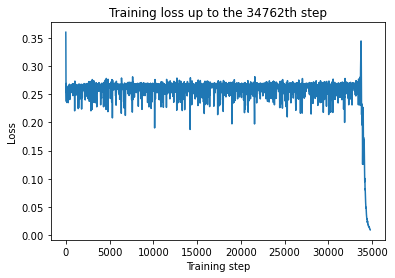

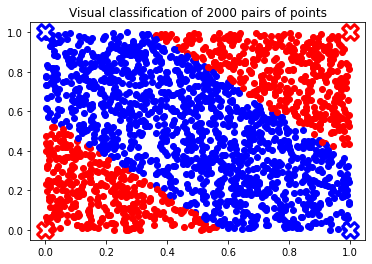

In [23]:
nn3 = NeuralNetwork([2,2,2,2], activation="tanh")
X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])
y=np.array([[1,0],
            [0,1],
            [0,1],
            [1,0]])

nn3.fit(X,y,steps=100000,tol=1e-2,live_update=False)
nn3.visual_NN_boundaries(X)

#### Live updates of loss and classification

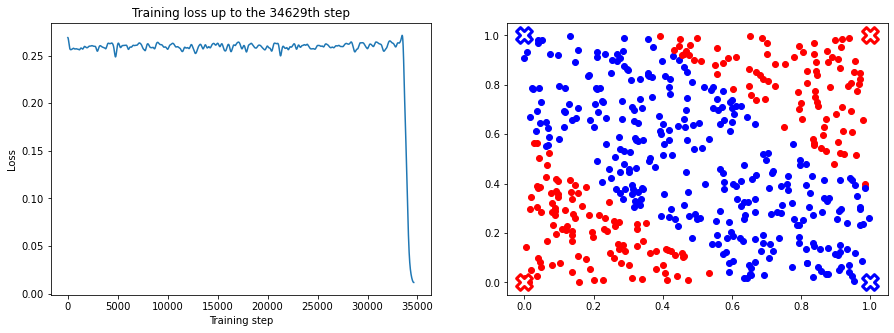

<Figure size 1080x360 with 0 Axes>

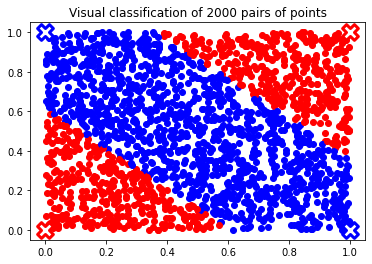

In [22]:
nn3 = NeuralNetwork([2,2,2,2], activation="tanh")
X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])
y=np.array([[1,0],
            [0,1],
            [0,1],
            [1,0]])

nn3.fit(X,y,steps=100000,tol=1e-2,update_step=1000,live_update=True)
nn3.visual_NN_boundaries(X)

### Two-label non-linear training set

#### Periodic printed updates

step: 0
Training Results (data, prediction, expected):
[0. 0.], [[0.46 0.54]], [1 0]
[0. 1.], [[0.4 0.6]], [1 0]
[0.5 1. ], [[0.36 0.64]], [1 0]
[0.  0.5], [[0.41 0.59]], [0 1]
[1. 0.], [[0.63 0.37]], [0 1]
[1. 1.], [[0.41 0.59]], [0 1]
1 step average loss: 0.4

step: 10000
Training Results (data, prediction, expected):
[0. 0.], [[0.81 0.19]], [1 0]
[0. 1.], [[0.73 0.27]], [1 0]
[0.5 1. ], [[0.65 0.35]], [1 0]
[0.  0.5], [[0.78 0.22]], [0 1]
[1. 0.], [[0.17 0.83]], [0 1]
[1. 1.], [[0.18 0.82]], [0 1]
100 step average loss: 0.15

step: 20000
Training Results (data, prediction, expected):
[0. 0.], [[0.83 0.17]], [1 0]
[0. 1.], [[0.7 0.3]], [1 0]
[0.5 1. ], [[0.44 0.56]], [1 0]
[0.  0.5], [[0.74 0.26]], [0 1]
[1. 0.], [[0.3 0.7]], [0 1]
[1. 1.], [[0.27 0.73]], [0 1]
100 step average loss: 0.18

step: 30000
Training Results (data, prediction, expected):
[0. 0.], [[0.83 0.17]], [1 0]
[0. 1.], [[0.71 0.29]], [1 0]
[0.5 1. ], [[0.61 0.39]], [1 0]
[0.  0.5], [[0.72 0.28]], [0 1]
[1. 0.], [[0.1

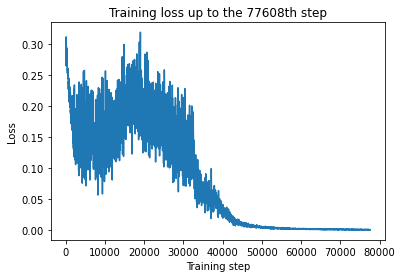

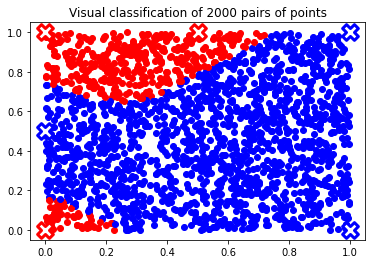

In [47]:
X = np.array([[0, 0],
              [0, 1],
              [0.5, 1],
              [0, 0.5],
              [1, 0],
              [1, 1]])
y=np.array([[1,0],
            [1,0],
            [1,0],
            [0,1],
            [0,1],
            [0,1]])

nn4 = NeuralNetwork([2,3,3,2], activation="tanh")

nn4.fit(X,y,learning_rate=0.02,steps = 100000,tol=1e-3,average_step_metric=100)
nn4.visual_NN_boundaries(X)

#### Live updates of loss and classification

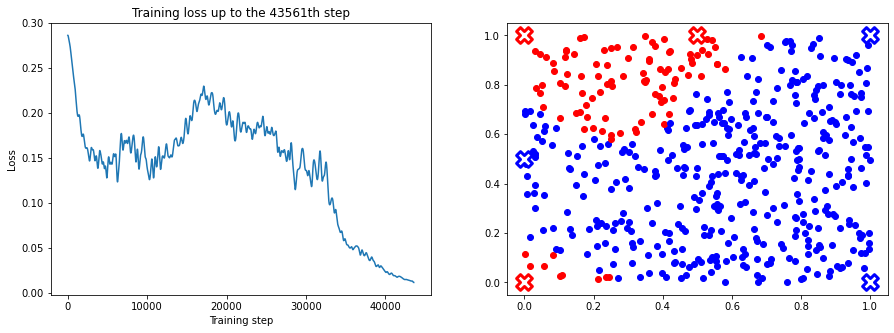

<Figure size 1080x360 with 0 Axes>

NN training succeeded!


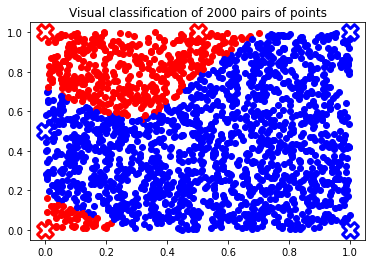

In [10]:
X = np.array([[0, 0],
              [0, 1],
              [0.5, 1],
              [0, 0.5],
              [1, 0],
              [1, 1]])
y=np.array([[1,0],
            [1,0],
            [1,0],
            [0,1],
            [0,1],
            [0,1]])

nn4 = NeuralNetwork([2,3,3,2], activation="tanh")

nn4.fit(X,y,learning_rate=0.02,steps = 100000,tol=1e-2,average_step_metric=100,update_step=10000,live_update=True)
nn4.visual_NN_boundaries(X)